<a href="https://colab.research.google.com/github/etienne-bnd/IA_Hands_Detection/blob/main/projet_automatant_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# presentation du projet
# dataset:


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import json
import numpy as np

In [ ]:
!wget https://lmb.informatik.uni-freiburg.de/data/freihand/FreiHAND_pub_v2.zip

!unzip /content/FreiHAND_pub_v2.zip

In [ ]:
data_train = "./training/rgb/"
image_size = [128, 128]
batch_size = 32

création du data_set avec les images

In [ ]:
train_data_set =  tf.keras.utils.image_dataset_from_directory(data_train, label_mode=None, batch_size = batch_size, image_size = image_size, shuffle = False).map(lambda x : x/255)

Found 130240 files belonging to 1 classes.


Affichage d'image du data set
(pas nécessaire de la lancer à chaque fois)

In [ ]:
plt.figure()
for elem in train_data_set:
  for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(elem[i])
    plt.axis("off")
  break

  plt.show()

on va créer le data set des labels
on ouvre training xyz et training k qui sont les coordonnées de la main et les coordonnées de la caméra puis on va les convertir en objets tensor flow

ouvrir fichier json (regarder internet) ça sera une liste, l'afficher, puis convertir en tensor flow (regarder sur internet pour convertir)
fichier json inspiré de j'écriture Java

In [ ]:
xyz_adresse = "./training_xyz.json"

In [ ]:
fichier_xyz = open(xyz_adresse, "r") # pour avoir l'adresse du fichier
xyzjson = json.load(fichier_xyz) # pour ouvrir un fichier json
xyz = tf.constant(xyzjson)
# print(xyz)

In [ ]:
K_adresse = "./training_K.json" # c'est l'adresse des fichier de la caméra
fichier_K = open(K_adresse, "r") # on ouvre le fichier
Kjson = json.load(fichier_K)
K = tf.constant(Kjson)
#print(K)


on a les coordonnées des labels en 3dimensions mais nous ce qu'on veut c'est les coordonnées des labels en 2D puisque on a des images en 2D. Dans l'article ils donnent une formule qui fonctionne image par image nous on veut faire tout d'un coup en utilisant des outils tensorflow pour optimiser les calculs.
la fonction:
def projectPoints(xyz, K):
  xyz = np.array(xyz)
  K = np.array(K)
  uv = np.matmul(K, xyz.T).T
  return uv[:, :2]/uv[:, -1:]


In [ ]:
xyz_t = tf.transpose(xyz, perm = [0, 2, 1])
uv = tf.transpose(tf.matmul(K, xyz_t), perm = [0, 2, 1])
label = uv[:, :, :2]/uv[:, :, -1:] # formule donnée dans l'article qui permet de passer les coordonnées de 3D à 2D
label = label*128/224 # on remet à la bonne taille les labels
#print(label)

on a donc converti les labels en 2D pour les mettre sur des images, comme le dataset répète 4 fois les mêmes images simplement en changeant le fond, il faut qu'on répète les éléments de uv 4 fois pour avoir le dataset final des labels.


In [ ]:
tensorlabel = tf.concat([label]*4, axis = 0)
#print(tensorlabel)

on obtient bien la taille voulue pour le tensor. il faut maintenant en faire un dataset.
On remet des batchs de la même taille que pour les images car on va tout traiter ensemble. on reprend la variable batch_size
drop_remainder = True sert à spécifier que si à la fin il reste des images dont le nombre ne fait pas  un batch on l'empêche d'en faire un plus petit car ça peut créer des erreurs. Le format des labels c'est qu'on a les coordonnées des différents labels pour une image. Il faut que l'on trouve un moyen de les afficher sur une figure.

In [ ]:
dataset_label = tf.data.Dataset.from_tensor_slices(tensorlabel).batch(batch_size, drop_remainder=True)
# print(dataset_label)
dataset_final = zip(train_data_set, dataset_label) #zip est une fonction interne qui prend deux ou plusieurs séquences et retourne une liste de tuples où chaque tuple contient un élément de chaque séquence

essai pour plot les labels mais qui n'a pas fonctionné très bien

In [ ]:
plt.figure() # pour pouvoir afficher une image
for elem in dataset_label:
  for i in range(16): # on parcours un batch
    plt.subplot(4, 4, i + 1)
    for diff_label in range(21):
     # print(elem[i][diff_label][0], elem[i][diff_label][1]) cette ligne était là pour débuger
      plt.plot(elem[i][diff_label][0], elem[i][diff_label][1]) # on regarde les coordonnées des labels et on les affiche
    plt.axis("off")
  break
plt.show()



---il faut afficher les labels?




In [ ]:
def plot_label(image, label):
    """
    Affiche une image avec les articulations représentées pour former les doigts.
    """
    # plt.grid(False)
    plt.imshow(image)
    color = ["b", "g", "r", "c", "m"]
    X = label[0].tolist()
    Y = label[1].tolist()
    for i in range(5):
        x = [X[0]] + X[4*i+1: 4*i+5]
        y = [Y[0]] + Y[4*i+1: 4*i+5]
        plt.plot(x,y, color[i])
        # plt.axis(False)
plot_label()
plt.show() # il reste à finir la partie affichage

TypeError: ignored

La fonction que thibault m'a envoyé qui fonctionne correctement

**séance 3**

On va essayer de passer les labels qui sont en 2D (coordonnées (x, y) en layer tableau de 128 * 128 qui est la densité de probabilité du point. On va mettre un 1 à l'endroit exact du point et puis on va flouter ça.
on va globalement utiliser la fonction: sparse.SparseTensor

In [ ]:
def label_a_layer(label):
  """ prend en entrée un label sous la forme d'un tupple de coordonnées (x,y) déjà compris entre 128*128 et renvoie un tableau
  """
  return tf.spare.SpareTensor(indice = [label[0], label[1]], values = [1], dense_shape = [128, 128])

mais nous on veut réaliser cette fonction pour tout le dataset d'un seul coup donc en prenant en compte les dimensions des batchs ect.. cette fonction sert juste à comprendre comment fonction la fonction SpareTensor

In [ ]:
def create_label_layers(label):
  """
  Créer les 21 couches des labels à partir des coordonnées
  Création tenseur avec des 1 aux coordonnées
  """
  label = tf.cast(label, dtype = tf.int64) #On change le type du tenseur de float à int
  label = tf.clip_by_value(label, 0, 127) #On écrete les valeurs extrèmes
  batch_lvl = tf.concat([tf.ones(21, dtype=tf.int64)*i for i in range(batch_size)], axis=0)
  point_lvl = tf.concat([tf.range(21, dtype=tf.int64)]*batch_size, axis=0)
  coordinates2 = tf.cast(label[:, :, 0], dtype=tf.int64) #On récupère les X
  coordinates1 = tf.cast(label[:, :, 1], dtype=tf.int64) #On récupère les Y
  indices = tf.stack([batch_lvl, tf.reshape(coordinates1, (batch_size*21,)),
                      tf.reshape(coordinates2, (batch_size*21,)), point_lvl], axis=-1)

  #Création d'un objet avec des 1 aux coordonnées des labels
  sparse_label = tf.sparse.SparseTensor(indices=indices, values=tf.ones(indices.shape[0]), dense_shape=(batch_size, 128, 128, 21))
  x = tf.sparse.reorder(sparse_label) #on réordonne les dimension pour le bon fonctionnement de l'opération
  not_sparse = tf.sparse.to_dense(x, validate_indices=False) #Conversion en tenseur
  return not_sparse

def gaussian_blur(img, kernel_size=11, sigma=3):
  """
  Applique un flou gaussien à une image
  """
  def gauss_kernel(channels, kernel_size, sigma):
      ax = tf.range(-kernel_size // 2 + 1.0, kernel_size // 2 + 1.0)
      xx, yy = tf.meshgrid(ax, ax)
      kernel = tf.exp(-(xx**2 + yy**2) / (2.0 * sigma ** 2))
      kernel = kernel / tf.reduce_sum(kernel)
      kernel = tf.tile(kernel[..., tf.newaxis], [1, 1, channels]) #On ajoute les autres couleurs
      return kernel

  gaussian_kernel = gauss_kernel(tf.shape(img)[-1], kernel_size, sigma)
  gaussian_kernel = gaussian_kernel[..., tf.newaxis]

  return tf.nn.depthwise_conv2d(img, gaussian_kernel, [1, 1, 1, 1], padding='SAME', data_format='NHWC')

on va maintenant appliqué au dataset des labels la fonction qui nous les mets en bloc 'en récupérant les coordonnées et  puis le flou gaussien

<ZipDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 128, 128, 21), dtype=tf.float32, name=None))>


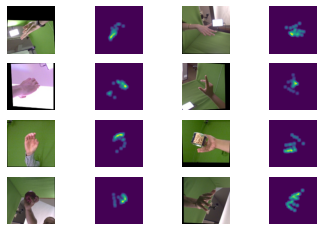

In [ ]:
def create_label(label): # cette fonction s'applique à un batch à la fois
  element = create_label_layers(label)
  return gaussian_blur(element, kernel_size=11, sigma=3)


def create_dataset():
 data_set_image = train_data_set # on créer d'abord le dataset des images ou on appelle celui qu'on a déjà créer
 data_set_label = dataset_label.map(create_label) # on créer le dataset des labels en appliquant les layers et le flou gaussien à un batch à la fois grâce à la fonction map
 return tf.data.Dataset.zip((data_set_image, data_set_label))# puis on zip les deux comme on avait fait avant (qui servait avt juste pour avoir des résultats visuels)


dataset_final = create_dataset()


## écriture d'un test pour afficher les éléments du dataset final
print(dataset_final)


j = 1
for elem in dataset_final: # on parcours les batchs du dataset

  for i in range(8): # on parcours les élements des batchs
    ax = plt.subplot(4, 4, 2*i + 1) # on divise en subplot
    plt.imshow(elem[0][i]) # 0 permet de rentrer dans le dataset des images
    plt.axis("off")
    ax = plt.subplot(4, 4, 2*i + 2) # on change sur le subplot juste à côté
    plt.imshow(tf.reduce_sum(elem[1][i], axis = -1)) # la fonction reduce permet de mettre les labels sur la même coordonnées en 2D (on n'applique pas comme avant parce que ici on a apppliqué le flou gaussien)
    plt.axis("off")
  break
plt.show()





nouvelle fonction utilitaire donnée par thibault

In [ ]:

def layers_to_coord(layers):
    """
    Convertie les layers en coordonnées.
    """
    try:
        layers = layers.numpy()
    except:
        None

    if len(layers.shape) == 3:
        Y_conv = np.array([[[i]*21]*128 for i in range(128)])
        X_conv = np.array([[[i]*21 for i in range(128)]]*128)
        for i in range(21):
            layers[:, :, i] /= np.sum(layers[:, :, i])
        x = np.sum(layers * X_conv, axis = (0,1))
        y = np.sum(layers * Y_conv, axis = (0,1))

    else:
        Y_conv = np.array([[[[i]*21]*128 for i in range(128)]]*len(layers))
        X_conv = np.array([[[[i]*21 for i in range(128)]]*128]*len(layers))
        for i in range(len(layers)):
            for j in range(21):
                layers[i, :, :, j] /= np.sum(layers[i, :, :, j])
        x = np.sum(layers * X_conv, axis = (1,2))
        y = np.sum(layers * Y_conv, axis = (1,2))

    return np.array([x, y])

